# Finetunning audio classification models

The following notebook shows how to finetune an audio classification model using the functionalities of HF ecosystem. We would use the [Audio Spectrogram Transformer](https://huggingface.co/MIT/ast-finetuned-audioset-10-10-0.4593) model to perform acoustic scene classification, a task that has been in the DCASE since it's origins.

We can divide in parts the process of finetunning a model

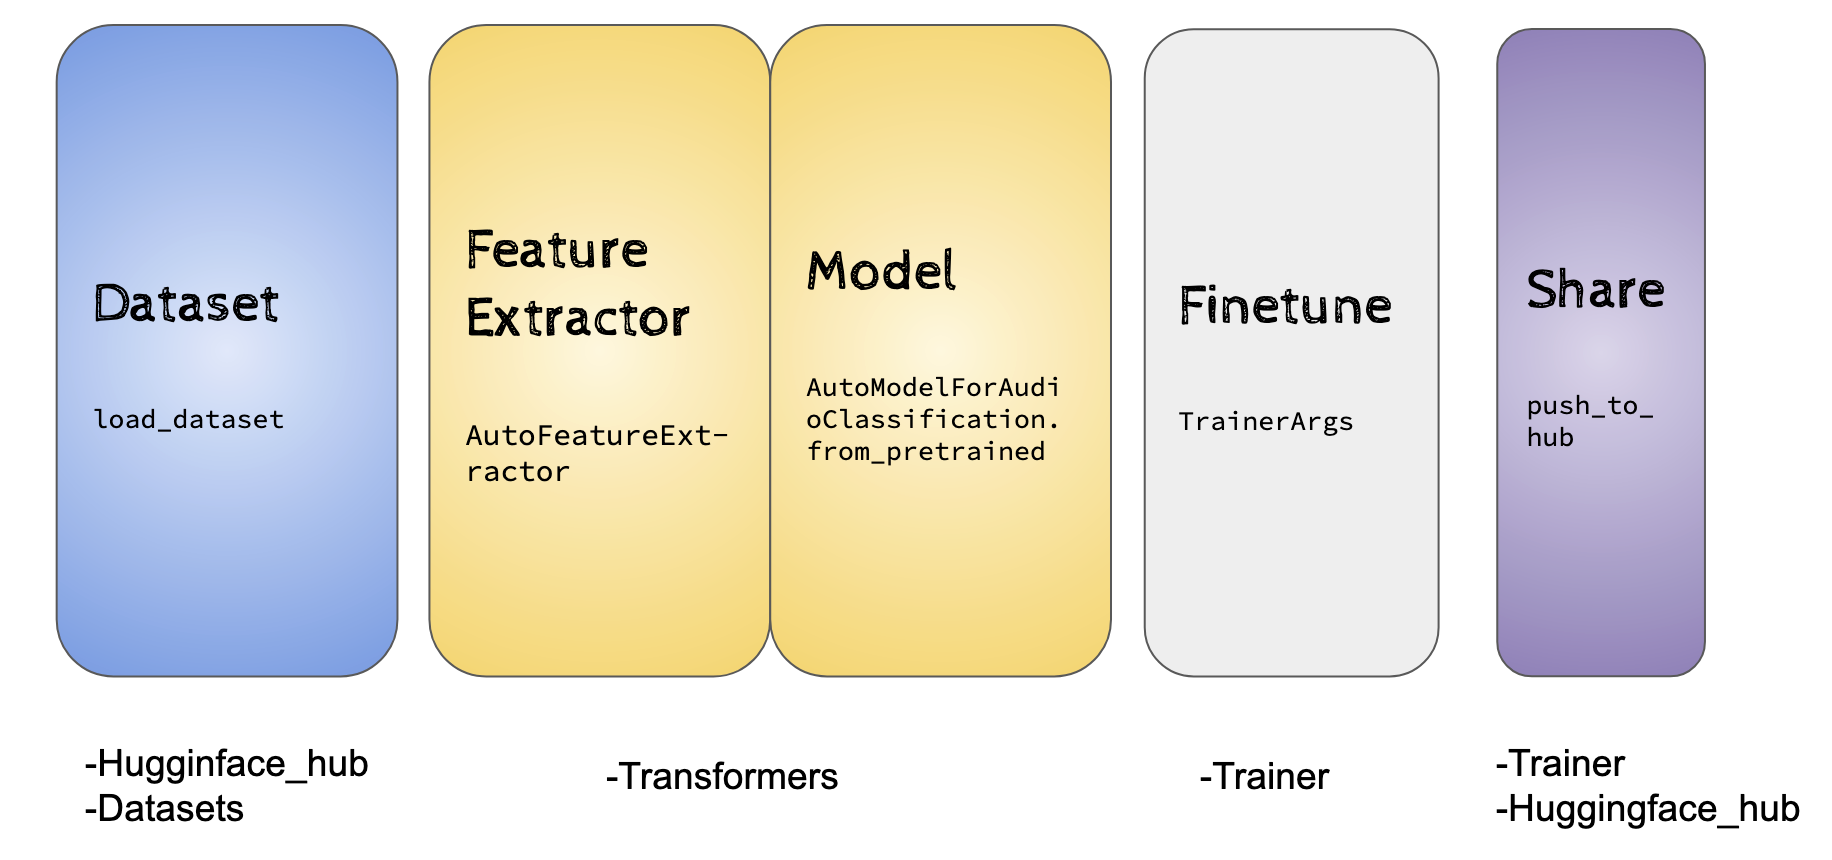

In [6]:
%%capture
!pip install datasets huggingface_hub evaluate
!pip install transformers[torch]
!pip install accelerate
!pip install pynvml

#Dataset

The first thing that we need is a dataset, as we saw earlier Datasets can be stored in the Huggingfacehub.

We are going to be using the ***TUT urban acoustic scenes 2018 dataset*** for this tutorial in streaming mode

In [7]:
from datasets import load_dataset, Audio

dataset = load_dataset("wetdog/TUT-urban-acoustic-scenes-2018-development-16bit", streaming="True")

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

# Model

Models on the hub are composed of a feature extractor and the model itself. The model that we choose takes as input 128 bin melspectrograms as can be seen from the diagram.

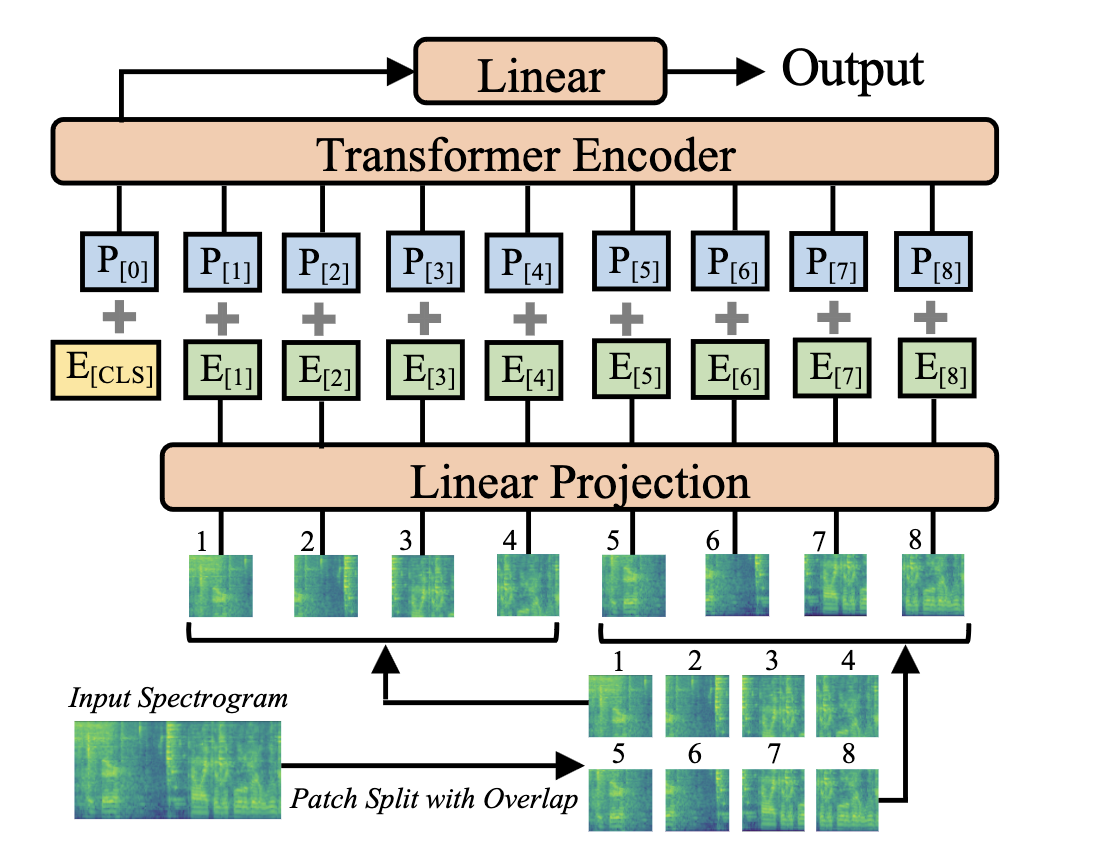


We would finetune this model changing the last linear layer with the 10 acoustic scenes labels of our dataset.

We have to load the model and the feature extractor using the classes `AutoFeatureExtractor`and  `AutoModelForAudioClassification`. Let's start with feature extractor!



## Feature Extractor

In [8]:
# Load feature extractor
from transformers import AutoFeatureExtractor

extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
print(extractor.__doc__)


    Constructs a Audio Spectrogram Transformer (AST) feature extractor.

    This feature extractor inherits from [`~feature_extraction_sequence_utils.SequenceFeatureExtractor`] which contains
    most of the main methods. Users should refer to this superclass for more information regarding those methods.

    This class extracts mel-filter bank features from raw speech using TorchAudio, pads/truncates them to a fixed
    length and normalizes them using a mean and standard deviation.

    Args:
        feature_size (`int`, *optional*, defaults to 1):
            The feature dimension of the extracted features.
        sampling_rate (`int`, *optional*, defaults to 16000):
            The sampling rate at which the audio files should be digitalized expressed in hertz (Hz).
        num_mel_bins (`int`, *optional*, defaults to 128):
            Number of Mel-frequency bins.
        max_length (`int`, *optional*, defaults to 1024):
            Maximum length to which to pad/truncate the e

let's apply the extractor to one of the examples in the dataset

In [19]:
try:
  example = next(iter(dataset["train"]))
  feature = extractor(example["audio"]["array"],example["audio"]["sampling_rate"])

except Exception as e:
  print(e)


We must the modify the dataset with the resampling step that would transform the audio signal to the expected sample rate of the model.

Using The cast() function that transforms the feature type of one or more columns, we can perform the resampling of the data.

extractors return a column feature with the name "input_values"

In [10]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
example = next(iter(dataset["train"]))
feature = extractor(example["audio"]["array"],example["audio"]["sampling_rate"])


In [11]:
feature["input_values"]

[array([[-0.7675132 , -1.1636301 , -0.78680784, ..., -0.7114712 ,
         -0.96829945, -1.2225931 ],
        [-1.0311371 , -1.176697  , -0.7998746 , ..., -0.70860904,
         -0.904821  , -1.2639027 ],
        [-0.6251457 , -0.97312844, -0.596306  , ..., -0.8339339 ,
         -1.0079765 , -1.2335619 ],
        ...,
        [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
          0.46703237,  0.46703237],
        [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
          0.46703237,  0.46703237],
        [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
          0.46703237,  0.46703237]], dtype=float32)]

Now we can see the transform that applies the feature extractor to the raw audio signal: a log mel spectrogram transform with 128 mel bins and the padding on the right to complete 1024 frames.

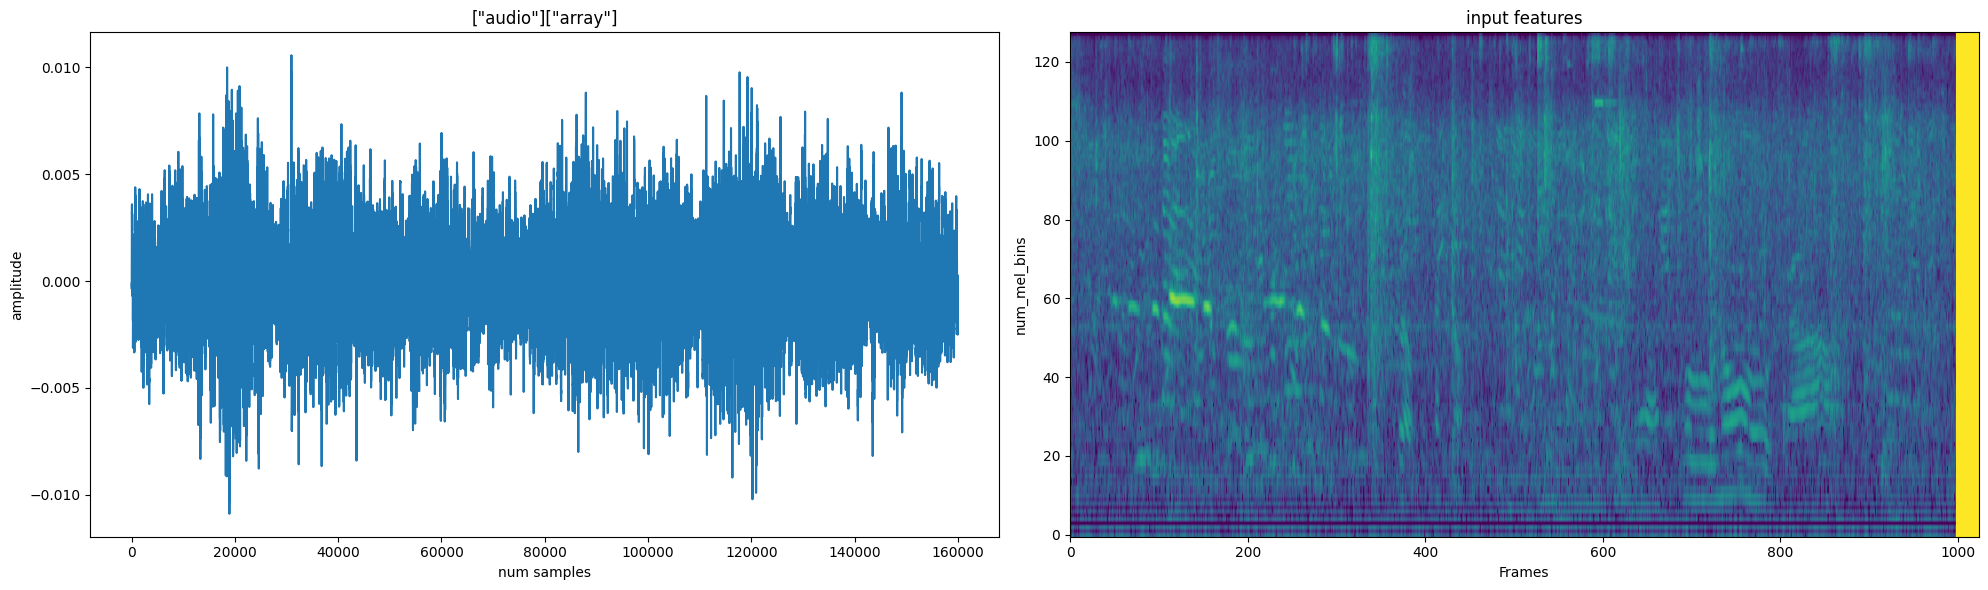

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2,nrows=1)


ax[0].plot(example["audio"]["array"])
ax[0].set_title('["audio"]["array"]')
ax[0].set_ylabel("amplitude");
ax[0].set_xlabel("num samples");

ax[1].imshow(feature["input_values"][0].T,origin="lower",aspect="auto")
ax[1].set_title("input features")
ax[1].set_ylabel("num_mel_bins");
ax[1].set_xlabel("Frames");

fig.set_size_inches(20,6)
plt.tight_layout()

Now that we tested the extractor we can define a preprocessing function that would do the extraction on a batch of examples.


In [13]:
def preprocess_function(examples):
  audio_arrays = [x["array"] for x in examples["audio"]]
  inputs = extractor(audio_arrays,sampling_rate=extractor.sampling_rate)
  return inputs

A function can be applied to a dataset using the map,  It allows you to apply a processing function to each example in a dataset, independently or in batches. This function can even create new rows and columns.

We apply the preprocessing function and also remove the audio column

In [14]:
# whole dataset
train_dataset = dataset["train"].shuffle(42)
test_dataset = dataset["test"].shuffle(42)

#train_dataset = dataset["train"].shuffle(42).take(4000)
#test_dataset = dataset["test"].shuffle(42).take(200)

encoded_dataset_val = test_dataset.map(preprocess_function, remove_columns=["audio"], batched=True)
encoded_dataset_train = train_dataset.map(preprocess_function, remove_columns=["audio"], batched=True)

## Finetuning a Model



Before loading the model to finetune, We have to create 2 dict mappings for the model:

    label2id: which converts the label to str
    id2label: which recover the str from the id

We apply the mapping to the dataset creating a new column called "labels", that will contain the ids of the classes

In [15]:
label2id = {"airport":0,
            "bus":1,
            "metro":2,
            "metro_station":3,
            "park":4,
            "public_square":5,
            "shopping_mall":6,
            "street_pedestrian":7,
            "street_traffic":8,
            "tram":9}

id2label = {i:label for label, i in label2id.items()}

encoded_dataset_val = encoded_dataset_val.map(lambda x: {"labels": label2id[x["label"]]}, remove_columns=["label"])
encoded_dataset_train = encoded_dataset_train.map(lambda x: {"labels": label2id[x["label"]]}, remove_columns=["label"])

Let's see a preproccesed example of the dataset

In [16]:
next(iter(encoded_dataset_train))

{'file_name': 'audio/shopping_mall-stockholm-137-4171-a.wav',
 'city': 'stockholm',
 'location_id': '137',
 'input_values': array([[-0.632073  , -0.8692804 , -0.49245805, ..., -0.83877355,
         -0.9366117 , -1.2257279 ],
        [-0.6814352 , -1.0186253 , -0.64180285, ..., -0.7917839 ,
         -0.9660429 , -1.260418  ],
        [-0.58664125, -0.85821867, -0.48139626, ..., -0.7318753 ,
         -0.90242   , -1.2077894 ],
        ...,
        [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
          0.46703237,  0.46703237],
        [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
          0.46703237,  0.46703237],
        [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
          0.46703237,  0.46703237]], dtype=float32),
 'labels': 6}

Now we load the model using the model handler, the mapping functions for the labels and the number of our classes.

In [17]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer, logging


model_handler = "MIT/ast-finetuned-audioset-10-10-0.4593"
num_labels = len(label2id)
model = AutoModelForAudioClassification.from_pretrained(
    model_handler,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)



Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Once loaded, we can print the model config to perform a check that the model is the one that we expect.

In [18]:
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (de

We define these 2 helper functions to check the memory occupied on our GPU

In [15]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

print_gpu_utilization()

GPU memory occupied: 258 MB.


# Trainer


We also have to define the metric that we would use for the task, this is done using the evaluate library of Huggingface. but you can also provide your own metric

In [16]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

Now instead of writing a training loop, we use the Trainer that would allows us to use advanced training techniques like gradient_accumulation, gradient_checkpointing, distributed training, mixed precision and many more.

In [17]:
model_name = model_handler.split("/")[-1]
batch_size = 4

args = TrainingArguments(
    f"{model_name}-TUT-acoustic-scenes",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    warmup_steps=50,
    logging_steps=25,
    save_steps=1000,
    eval_steps=500,
    load_best_model_at_end=True,
    max_steps=1000,
    report_to=["tensorboard"],
    metric_for_best_model="accuracy",
    push_to_hub=False,

)

In [18]:
logging.set_verbosity_error()

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_train,
    eval_dataset=encoded_dataset_val,
    compute_metrics=compute_metrics,
)

result = trainer.train()
print_summary(result)

Step,Training Loss,Validation Loss,Accuracy
500,0.272800,1.342259,0.630659


Step,Training Loss,Validation Loss,Accuracy
500,0.272800,1.342259,0.630659
1000,0.275200,0.713385,0.736696


Time: 6315.40
Samples/second: 2.53
GPU memory occupied: 10005 MB.


Lastly, we have to report the info of the training experiment to ensure reproducibility. This info would be added to the model card.

In [19]:
kwargs = {
    "dataset_tags": "acoustic-scenes",
    "dataset": "TUT-urban-acoustic-scenes-2018-development-16bit",  # a 'pretty' name for the training dataset
    "dataset_args":  "split: train",
    "model_name":  f"{model_name}-TUT-acoustic-scenes",  # a 'pretty' name for your model
    "finetuned_from": "wetdog/TUT-urban-acoustic-scenes-2018-development-16bit",
    "tasks": "audio-classification",
    "tags": "audio-classification",
}

In [ ]:
trainer.push_to_hub(**kwargs)

Note that we only uploaded the model, if we want to enable the inference directly on the hub we must upload the configuration of the feature extractor that we used.

In [ ]:
from huggingface_hub import HfApi


extractor.to_json_file("preprocessor_config.json")

api = HfApi()

api.upload_file(
    path_or_fileobj="/content/preprocessor_config.json",
    path_in_repo="preprocessor_config.json",
    repo_id=f"{username}/{model_name}-TUT-acoustic-scenes",
    repo_type="model",

)

# Final evaluation

In [21]:
predictions = trainer.predict(encoded_dataset_val)
print(predictions.predictions.shape, predictions.label_ids.shape)

(2518, 10) (2518,)


In [22]:
preds = np.argmax(predictions.predictions,axis=1)
results = accuracy_metric.compute(references=predictions.label_ids, predictions=preds)
print(results)

{'accuracy': 0.7366957903097696}


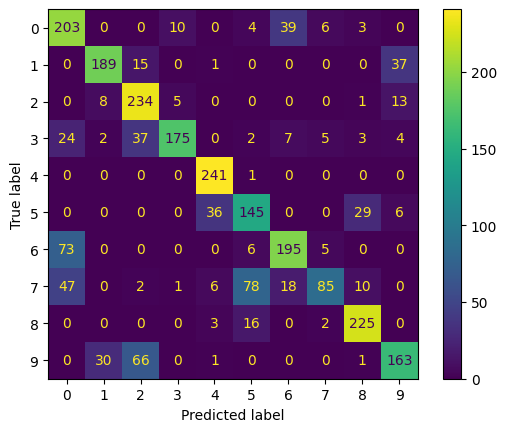

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(predictions.label_ids, preds);